In [2]:
import numpy as np
import scipy as sp
from fractions import Fraction
%matplotlib inline
import matplotlib.pyplot as plt   
import matplotlib.ticker

In [3]:
# Вывод вектора стратегии
def printVector(matrix, symbol):
    print("| ", symbol, " ||  ", end='')
    for j in range ( len(matrix[0]) ):
        print (str(matrix[0][j]).center(10), end = "  |  ") 
        #print("".format(matrix[0][j]))
    print ()

In [4]:
# Формируем матрицу для симплекс метода
def basic_matrix(matrix, n, m):
    
    frame = np.full((n+2, m+n+2), Fraction(0))
    
    # Добавляем в базовую матрицу платежную матрицу 
    for i in range(1, n+1):
        for j in range(2, m+2):
            frame[i,j] += Fraction(matrix[i-1,j-2]) 

    # Добавляем свободные коэффициенты
    frame[1:n+1,1] = Fraction(1)
    
    # Добавляем номера переменных базиса
    for i in range(1, n+1):
        frame[i,0] = Fraction(m + i)
        
    # Добавляем номера всех переменных (в том числе дополнительные)
    for j in range(2, m+n+2):
        frame[0,j] = Fraction(j-1)
        
    # Добавляем коэффициенты для целевой функции
    frame[n+1, 2:m+2] = Fraction(-1)
    for k in range(0, n):
        frame[k+1,m+2+k] = 1
        
    return frame

In [5]:
# Поиск лидирующего столбца , строки и элемента
def leaders(a, n, m):
    
    flag = False    # Флаг = тру, когда появился первый элекмент, удовлетворяющий условиям
    
    # Поиск ведущего столбца
    for j in range(2, m+n+2):
        if a[n+1, j] < 0:
            if flag == False:
                lead_column = j
                flag = True
            else:
                if abs(a[n+1, j]) >= abs(a[n+1, lead_column]):
                    lead_column = j
    
    flag = False     # Флаг = тру, когда появился первый элекмент, удовлетворяющий условиям
    
    # Поиск ведущей строки 
    for i in range(1, n+1):
        if not(((a[i, 1] > 0) and (a[i, lead_column] < 0)) or (a[i, lead_column] == 0) or (a[i, 1] == 0)):
            if flag == False:
                lead_line = i
                exp = (a[lead_line, 1])/(a[lead_line, lead_column])
                flag = True
            else: 
                if (a[i, 1])/a[i, lead_column] < exp:
                    exp = (a[i, 1])/a[i, lead_column]
                    lead_line = i
    
    # Ведущий элемент
    lead_elem = a[lead_line, lead_column]
    
    return lead_column, lead_line, lead_elem

In [6]:
# Процесс перехода к новой матрице по идее симплекс метода
def smplx_mthd(a,n,m):

    # Лидирующий строка, столбец и элемент
    lead_column, lead_line, lead_elem = leaders(a, n, m)
    
    # Получаем номер переменной. которую необходимо добавить в базис
    var_chg = a[0, lead_column]

    new_smplx_mtrx = a.copy()
    new_smplx_mtrx[lead_line, 0] = var_chg    # Добавляем найденную переменную в базис
    
    # Заполняем лидирующую строку новой таблицы
    for j in range(1, m+n+2):
        new_smplx_mtrx[lead_line, j] = (a[lead_line, j])/(lead_elem)
        
    # Заполняем все остальные строки
    for i in range(1, n+2):
        for j in range(1, m+n+2):
            if i != lead_line:
                new_smplx_mtrx[i, j] = a[i, j] - ((a[i, lead_column]) * (a[lead_line, j]))/lead_elem

    return new_smplx_mtrx

In [7]:
# Проверка матрицы на наличие седловой точки
def check_matrix(mx):
    
    # Переменные для номера строки(слобца) для оптимальной стратегии 1(2)
    # игрока в случе седловой точки
    optimal_strategy_1 = 0
    optimal_strategy_2 = 0
    
    # дробное представление элементов матрицы(для удобства работы)
    for i in range (len(mx)):
        for j in range (len(mx[0])):
            mx[i][j] = Fraction(mx[i][j])
        
    flag = False    # Флаг = тру, когда появился первый элекмент, удовлетворяющий условиям
    k = 0    #  номер сироки  
    
    # Поиск maxmin'а
    for i in list(mx):
        if flag == False:
            max_for_maxmin = i.min()
            flag = True
        else:
            if i.min() > max_for_maxmin:
                max_for_maxmin = i.min()
                optimal_strategy_1 = k
        k += 1
        
    flag = False    # Флаг = тру, когда появился первый элекмент, удовлетворяющий условиям
    k = 0    #  номер сироки  
    
    # Поиск minmax'а
    for j in list(mx.T):
        if flag == False:
            min_for_minmax = j.max()
            flag = True
        else:
            if j.max() < min_for_minmax:
                min_for_minmax = j.max()
                optimal_strategy_2 = k
        k +=1
                
    # Если answer = True, то имеется седловая точка
    if max_for_maxmin == min_for_minmax:
        answer = True
    else:
        answer = False
        
    return answer, max_for_maxmin, optimal_strategy_1, optimal_strategy_2

In [8]:
def nash_equilibrium(a):

    n = a.shape[0]       # число строк
    m = a.shape[1]       # число столбцов
    
    # Проверка на наличие седловой точки
    saddle_point, v, opt_strateg_1, opt_strateg_2 = check_matrix(a)
    
    if saddle_point == True:
        # Векторы оптимальных стратегий (первого и второго игрока соответственно)
        first_answer = np.full((1, m), Fraction(0))
        second_answer = np.full((1, n), Fraction(0))
        for i in range(0,m):
            first_answer[0, i] = a[opt_strateg_1, i]
        for i in range(0,n):
            second_answer[0, i] = a[i, opt_strateg_2]
            
    # Если седловой точки нет - используем симплекс метод
    else:
        # Векторы оптимальных стратегий (первого и второго игрока соответственно)
        first_answer = np.full((1, n), Fraction(0))
        second_answer = np.full((1, m), Fraction(0))
        
        smplx_mtrx = basic_matrix(a,n,m)   # первая симплексная таблица
        
        # Вектор последней строки таблицы с переменными, для проверки условия оптимальности
        answer = smplx_mtrx[n+1, 2:m+n+2].copy() 
        answer.sort()

        # Цикл симплекс метода
        while (answer[0] < 0):
            new_smplx_mtrx = smplx_mthd(smplx_mtrx,n,m)  # Получаем следующую матрицу

            # Вектор последней строки таблицы с переменными, для проверки условия оптимальности
            answer = new_smplx_mtrx[n+1, 2:m+n+2].copy()
            answer.sort()
            smplx_mtrx = new_smplx_mtrx
            
        # Функции
        f1, f2 = 0, 0

        # заполняем векторы оптимальных стратегий 
        for i in range(1, n+1):
            var_num = int(smplx_mtrx[i,0])
            if var_num <= m :
                f2 += smplx_mtrx[i, 1]
                second_answer[0, (var_num - 1)] = smplx_mtrx[i, 1]
            first_answer[0,(i-1)] =  smplx_mtrx[n+1,i + m +1]
            f1 += smplx_mtrx[n+1,i+m+1]

        # Значение игры
        v = Fraction(1)/f1
        
        first_answer = first_answer*v
        second_answer = second_answer*v
    
    return v, first_answer, second_answer

In [9]:
def visualization_of_spectra(a):
    
    i = 0
    
    y = a[0, :]
    x = np.arange(1, np.size(a)+1)
    
    fig, ax = plt.subplots()
    ax.set_title('Визуализация спектров')
    
    y_major = 0.1
    y_minor = 0.02
    
    # Случай седловой точки
    if a.max() > 1:
        y_major = 1
        y_minor = 1
        
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(y_major))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(y_minor))
      
    ax.bar(x, y, width = 0.02, color=(0.2, 0.4, 0.6, 0.6))
    ax.plot(x, y, marker = 'o', linestyle = '')

In [10]:
example = np.array([
    [4,0,6,2,2,1],
    [3,8,4,10,4,4],
    [1,2,6,5,0,0],
    [6,6,4,4,10,3],
    [10,4,6,4,0,9],
    [10,7,0,7,9,8]
])

Значение игры = 0
|  p  ||      0       |      0       |      6       |      0       |  
|  q  ||      0       |      0       |      0       |      0       |  


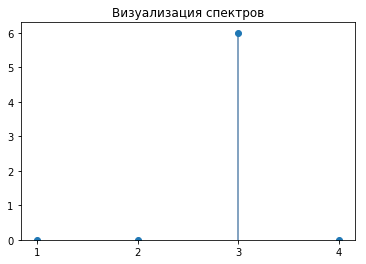

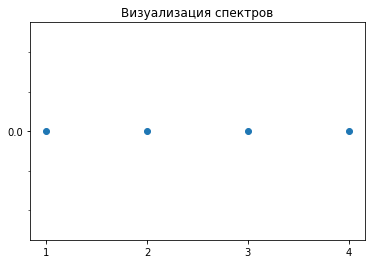

In [12]:
v,s1,s2 = nash_equilibrium(doesntwork)
print("Значение игры =", v)
printVector(s1, 'p')
printVector(s2, 'q')
visualization_of_spectra(s1)
visualization_of_spectra(s2)

In [400]:
vv = np.array([
    [0,0],
    [0,4]
])

In [405]:
m = np.array([[1  ,-2  ,7    ,22  ,1],\
                           [2  ,3   ,4    ,4   ,-11],\
                           [2  ,33  ,-44  ,1   ,-1],\
                           [5  ,4   ,-3   ,2   ,-123]])

In [13]:
doesntwork = np.array([[0, 0, 6, 0],
                        [0, 0, 5, 0],
                        [0, -1, 3, 2],
                        [0, 0, 4, 0]
])